<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in this assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Key part of this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

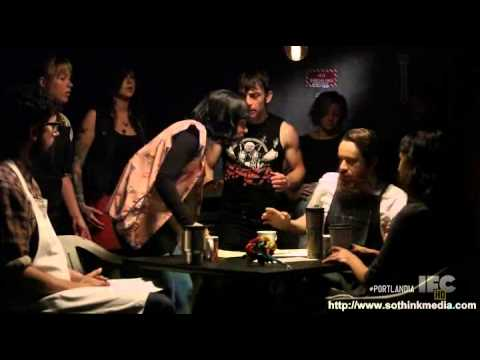

In [114]:
from IPython.display import YouTubeVideo

YouTubeVideo('Jml7NVYm8cs')

In [115]:
%pwd

'C:\\Users\\Ben\\Lambda\\unit4\\DS-Unit-4-Sprint-1-NLP\\module1-text-data'

In [116]:
import pandas as pd

url = "https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/master/module1-text-data/data/yelp_coffeeshop_review_data.csv"

shops = pd.read_csv(url)
shops.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,"11/25/2016 1 check-in Love love loved the atmosphere! Every corner of the coffee shop had its own style, and there were swings!!! I ordered the matcha latte, and it was muy fantastico! Ordering and getting my drink were pretty streamlined. I ordered on an iPad, which included all beverage selections that ranged from coffee to wine, desired level of sweetness, and a checkout system. I got my latte within minutes! I was hoping for a typical heart or feather on my latte, but found myself listing out all the possibilities of what the art may be. Any ideas?",5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambiance in Austin BEAUTIFUL!!!! Love the ambiance! Instagram-worthy!!! Definitely $$$, so be prepared. This is gonna cost you a pretty penny :) Waffle dessert was just decent...nothing to rave about. But, will probably be back just to be somewhere unique and nice.",4.0 star rating
2,The Factory - Cafe With a Soul,"11/30/2016 1 check-in Listed in Brunch Spots I loved the eclectic and homey plush decor and who doesn't want to swing and drink their coffee? I would categorize this as a pricier coffee place but, to me it was worth it. After Thanksgiving nobody wants to make brunch so we headed out in search of chicken and waffles. There is ample parking in the private lot and ordering is done through I-Pads. Pick a seat and they will call your name when your items are ready. Be patient because some of the coffee drinks take longer than others. I had the cold brew coffee, chicken and waffles and we shared a pop+art! The po+art was strawberry; light and fluffy on the outside and gooey sweet filling on the inside. The chicken and waffles wasn't the standard so expect different, complex and interesting flavors from the accompanying slaw and sauce. I thoroughly enjoyed it but, the waffle was a bit bland and maybe could have used a bit of honey to spruce it up. The coffee here is spot on and I hear that their hot chocolate is the bomb but, I will have to wait for the weather to cool off to try that. A great place to be cozy and chat with your friends, a date or read a book. Chicken and waffles Pop tart Coffee See all photos from Carmela S. for The Factory - Cafe With a Soul",4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice seating However... Just about everything is overpriced. $1.50 extra for 3 ounces of Almond Milk in a cortado. No WiFi Music is a bit loud and the mix is odd. Pleasant French oldies followed by loud techno. Several tables were dirty when we got there. Service is average. It feels like a Los Angeles coffee shot that is out of place.,2.0 star rating
4,The Factory - Cafe With a Soul,"12/3/2016 1 check-in They are located within the Northcross mall shopping center facing east toward Burnet Rd with plenty of parking. I loved their computerized user friendly ordering system, it made it easy me to pick & choose all the items I wanted to try. I ordered pop tart, chicken & waffles, strawberry waffles (photos uploaded). This place is ideal for ordering a few dishes to share with your group. Seating is limited since this place is fairly new with lots of visitors. Arrive early and be prepared to wait a bit if you with a large grop. Store front facing Burnet Rd See all photos from Michelle A. for The Factory - Cafe With a Soul",4.0 star rating


## How do we want to analyze these coffee shop tokens? 

- Overall Word / Token Count
- View Counts by Rating 
- *Hint:* a 'bad' coffee shops has a rating betweeen 1 & 3 based on the distribution of ratings. A 'good' coffee shop is a 4 or 5. 

In [117]:
# First things first: drop words from star rating and make int

def clean_stars(rating):
    return int(rating[1])

shops['star_rating'] = shops['star_rating'].apply(clean_stars)

In [118]:
# Remove duplicate rows

shops = shops.drop_duplicates(subset=['full_review_text', 'coffee_shop_name', 'star_rating'])

In [119]:
pd.set_option('display.max_colwidth', 0)
shops.sample(20)

,coffee_shop_name,full_review_text,star_rating
1276,Caffé Medici,"11/12/2016 Good place for drinking a mocha and hanging out with friends and maybe light work on-the-go. Internet though, isn't reliable enough to frequent often especially with a full house.",3
1066,Epoch Coffee,"10/15/2014 4 check-ins That area needed a good coffeehouse and this was it. I was sick and tired of going to a coffeehouse which I'm going to name but I'll give you a hint - they have private events scheduled and they will kick you out of the room. Then you have to fend for yourself. I didn't want to go to Starbucks either. It's a nice area with old school furniture and there are board games. Their coffee hits the spot. If I'm in the area, this is where I'm going to get some good coffee.",4
3935,Lola Savannah Coffee Lounge,"6/3/2012 Lola Savannah's got me licking my lips more than LL Cool J in the 90's!! This is by far my favorite coffee shop in Austin! It's not really in the city, but it's worth the extra five minutes for a very comfortable cup of your favorite coffee. First and foremost, they've got some of the best espresso machines you can buy. They look like they came from Metropolis. They're coffee beans are roasted outside of Houston at the original Lola Savannah (which I believe is the owner's mother's place). The baristas care about coffee and making it correctly which seems to be a fabled myth in the corporate coffee world we are surrounded by. They're always playin' good music, the seating is spacious and very comfy and they have really good breakfast tacos and pastries. Oh, and they're connected to The Grove so you can enjoy that great wine selection. Serious recommendation from a fairly serious Yelper.",5
557,Apanas Coffee & Beer,"4/29/2016 4 check-ins So I don't know much about coffee, but their drip coffee is good enough to drink black. Their beans are fair trade, so that's also a plus if you're into that. They also have a beer and wine selection ($1 off on Mondays-Fridays from 4-7!) The staff are super friendly and keep everything really organized and clean. I love coming here to study. It's the perfect mix of people who come here to study and socialize so there's always a quiet background buzz. There are big store front windows which let in natural light and makes the place seem very open even when it gets crowded during lunchtime rushes when people swing by to grab a cup of coffee on the go. They also have a small collection of games you can play if you need a study break or just want to play games (bananagrams, jenga, and chess, to name a few). Green tea tropical iced tea",5
4267,Irie Bean Coffee Bar,"9/9/2009 2 check-ins Listed in Best drinking (coffee and/or adult) Irie Bean Coffee Bar A relatively new place in my rotating selection of coffee houses. This place gets mad props for several reasons: open mic nights, coffee AND beer, super pet friendly. And super helpful (and cute) counter staff. The seating area inside isn't the largest or roomiest but the backyard more than makes up for it. Like the vibe of Fair Bean-maybe not the coffee house vibe for everyone-but a breath of fresh air for those of us tired of pretentious cups of joe. 4 out of 5 stars and I can't wait to go back. Try the Guiness/Espresso beverage (forget what it is called, ""Irie Bomb"" maybe...but MAN is it GOOD!!!!!!!!!!!!!!!) the breakfast of champions!",4
2501,Caffé Medici,"3/27/2013 1 check-in Listed in 2013 Yelp 100 Challenge, The best part of waking up is Cuvée in your cup! Caffé Medici, you're pretty cute. I really like their hot chocolate. It's everything hot chocolate should be. It's rich without being overpowering and it's smooth. The raspberry Italian soda is also pretty tasty - it's light and refreshing and I imagine it would be quite good on a hot summer's day. I don't drink coffee, so I can't comment on their coffee drinks. The atmosphere is very open. I feel like I can have a quiet conversation here and no one will care, but I can also come here to ge

Visual analysis suggests dates at beginning of review and extra words in star rating are consistent data bugs, but that there probably aren't many others.

I'd like to see how many distinct coffee shops are rated, and make sure names are consistently rendered...

In [120]:
pd.set_option('display.max_rows', 1000)
shops['coffee_shop_name'].value_counts()

Epoch Coffee                            200
Houndstooth Coffee                      200
Caffé Medici                            143
Apanas Coffee & Beer                    118
The Buzz Mill                           100
Patika                                  100
Cherrywood Coffeehouse                  100
Once Over Coffee Bar                    100
Summermoon Coffee Bar                   100
Sorrento’s Coffee                       100
Cenote                                  100
Summer Moon Coffee Bar                  100
Jo’s Coffee                             100
La Tazza Fresca                         100
Seventh Flag Coffee Co                  100
Café Crème                              100
Mary’s Cafe                             100
Radio Coffee & Beer                     100
Thunderbird Coffee                      100
Bennu Coffee                            100
La Patisserie                           100
Vintage Heart Coffee                    100
Teo                             

Well, there don't appear to be any conspicuously similar shop names, anyway. 

The dates I can strip using python string slicing. These could be featurized. It might be interesting to see how ratings and language correlate with seasons.

I'm not totally sure what to do about the "1 check-in" that precedes some reviews. Might be worth looking into removing those, or even featurizing them.

Let's use the function from class to tokenize these reviews.

In [121]:
def tokenize(text):
    """Parses a string into a list of semantic units (words)

    Args:
        text (str): The string that the function will tokenize.

    Returns:
        list: tokens parsed out by the mechanics of your choice
    """
    
    tokens = re.sub(r'[^a-zA-Z ^0-9]', '', text)
    tokens = tokens.lower().split()
    
    # Remove date from list of tokens
    tokens = tokens[1:]
    
    # Remove '1 check-in' from list of tokens
    
    return tokens

In [122]:
import re
shops['review_tokens'] = shops['full_review_text'].apply(tokenize)

In [123]:
shops['review_tokens']

0       [1, checkin, love, love, loved, the, atmosphere, every, corner, of, the, coffee, shop, had, its, own, style, and, there, were, swings, i, ordered, the, matcha, latte, and, it, was, muy, fantastico, ordering, and, getting, my, drink, were, pretty, streamlined, i, ordered, on, an, ipad, which, included, all, beverage, selections, that, ranged, from, coffee, to, wine, desired, level, of, sweetness, and, a, checkout, system, i, got, my, latte, within, minutes, i, was, hoping, for, a, typical, heart, or, feather, on, my, latte, but, found, myself, listing, out, all, the, possibilities, of, what, the, art, may, be, any, ideas]                              
1       [listed, in, date, night, austin, ambiance, in, austin, beautiful, love, the, ambiance, instagramworthy, definitely, so, be, prepared, this, is, gonna, cost, you, a, pretty, penny, waffle, dessert, was, just, decentnothing, to, rave, about, but, will, probably, be, back, just, to, be, somewhere, unique, and, nice]          

In [124]:
from collections import Counter

# And the function from class to count the words...

def count(docs):

    word_counts = Counter()
    appears_in = Counter()

    total_docs = len(docs)

    for doc in docs:
        word_counts.update(doc)
        appears_in.update(set(doc))

    temp = zip(word_counts.keys(), word_counts.values())

    wc = pd.DataFrame(temp, columns = ['word', 'count'])

    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()

    wc['pct_total'] = wc['count'].apply(lambda x: x / total)

    wc = wc.sort_values(by='rank')
    wc['cul_pct_total'] = wc['pct_total'].cumsum()

    t2 = zip(appears_in.keys(), appears_in.values())
    ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
    wc = ac.merge(wc, on='word')

    wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)

    return wc.sort_values(by='rank')

In [125]:
wc = count(shops['review_tokens'])

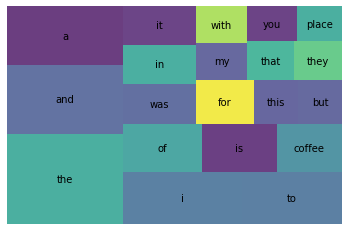

In [126]:
import squarify
import matplotlib.pyplot as plt

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

## Use Spacy to tokenize and remove stop words from tokens

In [127]:
import spacy

nlp = spacy.load("en_core_web_lg")

In [128]:
from spacy.tokenizer import Tokenizer

tokenizer = Tokenizer(nlp.vocab)

In [129]:
shops.head()

,coffee_shop_name,full_review_text,star_rating,review_tokens
0,The Factory - Cafe With a Soul,"11/25/2016 1 check-in Love love loved the atmosphere! Every corner of the coffee shop had its own style, and there were swings!!! I ordered the matcha latte, and it was muy fantastico! Ordering and getting my drink were pretty streamlined. I ordered on an iPad, which included all beverage selections that ranged from coffee to wine, desired level of sweetness, and a checkout system. I got my latte within minutes! I was hoping for a typical heart or feather on my latte, but found myself listing out all the possibilities of what the art may be. Any ideas?",5,"[1, checkin, love, love, loved, the, atmosphere, every, corner, of, the, coffee, shop, had, its, own, style, and, there, were, swings, i, ordered, the, matcha, latte, and, it, was, muy, fantastico, ordering, and, getting, my, drink, were, pretty, streamlined, i, ordered, on, an, ipad, which, included, all, beverage, selections, that, ranged, from, coffee, to, wine, desired, level, of, sweetness, and, a, checkout, system, i, got, my, latte, within, minutes, i, was, hoping, for, a, typical, heart, or, feather, on, my, latte, but, found, myself, listing, out, all, the, possibilities, of, what, the, art, may, be, any, ideas]"
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambiance in Austin BEAUTIFUL!!!! Love the ambiance! Instagram-worthy!!! Definitely $$$, so be prepared. This is gonna cost you a pretty penny :) Waffle dessert was just decent...nothing to rave about. But, will probably be back just to be somewhere unique and nice.",4,"[listed, in, date, night, austin, ambiance, in, austin, beautiful, love, the, ambiance, instagramworthy, definitely, so, be, prepared, this, is, gonna, cost, you, a, pretty, penny, waffle, dessert, was, just, decentnothing, to, rave, about, but, will, probably, be, back, just, to, be, somewhere, unique, and, nice]"
2,The Factory - Cafe With a Soul,"11/30/2016 1 check-in Listed in Brunch Spots I loved the eclectic and homey plush decor and who doesn't want to swing and drink their coffee? I would categorize this as a pricier coffee place but, to me it was worth it. After Thanksgiving nobody wants to make brunch so we headed out in search of chicken and waffles. There is ample parking in the private lot and ordering is done through I-Pads. Pick a seat and they will call your name when your items are ready. Be patient because some of the coffee drinks take longer than others. I had the cold brew coffee, chicken and waffles and we shared a pop+art! The po+art was strawberry; light and fluffy on the outside and gooey sweet filling on the inside. The chicken and waffles wasn't the standard so expect different, complex and interesting flavors from the accompanying slaw and sauce. I thoroughly enjoyed it but, the waffle was a bit bland and maybe could have used a bit of honey to spruce it up. The coffee here is spot on and I hear that their hot chocolate is the bomb but, I will have to wait for the weather to cool off to try that. A great place to be cozy and chat with your friends, a date or read a book. Chicken and waffles Pop tart Coffee See all photos from Carmela S. for The Factory - Cafe With a Soul",4,"[1, checkin, listed, in, brunch, spots, i, loved, the, eclectic, and, homey, plush, decor, and, who, doesnt, want, to, swing, and, drink, their, coffee, i, would, categorize, this, as, a, pricier, coffee, place, but, to, me, it, was, worth, it, after, thanksgiving, nobody, wants, to, make, brunch, so, we, headed, out, in, search, of, chicken, and, waffles, there, is, ample, parking, in, the, private, lot, and, ordering, is, done, through, ipads, pick, a, seat, and, they, will, call, your, name, when, your, items, are, ready, be, patient, because, some, of, the, coffee, drinks, take, longer, than, others, i, had, the, ...]"
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice seating However... Just about 

In [130]:
### Let's check out these stop words

nlp.Defaults.stop_words

{"'d",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'ve",
 'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amount',
 'an',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'around',
 'as',
 'at',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'both',
 'bottom',
 'but',
 'by',
 'ca',
 'call',
 'can',
 'cannot',
 'could',
 'did',
 'do',
 'does',
 'doing',
 'done',
 'down',
 'due',
 'during',
 'each',
 'eight',
 'either',
 'eleven',
 'else',
 'elsewhere',
 'empty',
 'enough',
 'even',
 'ever',
 'every',
 'everyone',
 'everything',
 'everywhere',
 'except',
 'few',
 'fifteen',
 'fifty',
 'first',
 'five',
 'for',
 'former',
 'formerly',
 'forty',
 'four',
 'from',
 'fron

In [131]:
STOP_WORDS = nlp.Defaults.stop_words.union([' ', 'coffee', 'place', 'great', "it's", 'like', 'good', '1', 'check-in', "i'm", "i've", 'review', 'check-ins'])

remove_list = ['alone', 'amount', 'empty']
type(STOP_WORDS)
for word in remove_list:
    print("removing", word)
    STOP_WORDS.remove(word)

removing alone
removing amount
removing empty


In [132]:
tokens = []

for doc in tokenizer.pipe(shops['full_review_text'], batch_size=500):
    doc_tokens = []
    
    for token in doc:
        if (token.text.lower() not in STOP_WORDS) & (token.is_punct == False):
            doc_tokens.append(token.text.lower())
    
    
    doc_tokens = doc_tokens[2:]
    
    tokens.append(doc_tokens)

shops['tokens'] = tokens

In [133]:
# Okay, here's the properly tokenized list:

In [134]:
shops['tokens']

0       [love, loved, atmosphere!, corner, shop, style,, swings!!!, ordered, matcha, latte,, muy, fantastico!, ordering, getting, drink, pretty, streamlined., ordered, ipad,, included, beverage, selections, ranged, wine,, desired, level, sweetness,, checkout, system., got, latte, minutes!, hoping, typical, heart, feather, latte,, found, listing, possibilities, art, be., ideas?]                                                                                                                                                                                                                                                                                                                                                                                                                                         
1       [date, night:, austin,, ambiance, austin, beautiful!!!!, love, ambiance!, instagram-worthy!!!, definitely, $$$,, prepared., gonna, cost, pretty, penny, waffle, dessert, decent...nothing,

In [135]:
# Let's take a look at a graph...

wc = count(shops['tokens'])
wc.head(20)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
11,love,1097,1362,1.0,0.004273,0.004273,0.158641
775,little,1124,1345,2.0,0.004220,0.008493,0.162545
274,don't,992,1226,3.0,0.003846,0.012339,0.143456
381,food,967,1209,4.0,0.003793,0.016132,0.139841
624,time,970,1183,5.0,0.003711,0.019844,0.140275
154,nice,1020,1173,6.0,0.003680,0.023524,0.147505
27,pretty,910,1140,7.0,0.003577,0.027100,0.131598
36,got,875,1112,8.0,0.003489,0.030589,0.126537
931,people,896,1081,9.0,0.003391,0.033981,0.129573
42,austin,933,1075,10.0,0.003373,0.037353,0.134924


In [136]:
shops['star_rating'].value_counts()

5    3446
4    2143
3    670 
2    403 
1    253 
Name: star_rating, dtype: int64

In [137]:
shops[shops['star_rating'] >= 4]

,coffee_shop_name,full_review_text,star_rating,review_tokens,tokens
0,The Factory - Cafe With a Soul,"11/25/2016 1 check-in Love love loved the atmosphere! Every corner of the coffee shop had its own style, and there were swings!!! I ordered the matcha latte, and it was muy fantastico! Ordering and getting my drink were pretty streamlined. I ordered on an iPad, which included all beverage selections that ranged from coffee to wine, desired level of sweetness, and a checkout system. I got my latte within minutes! I was hoping for a typical heart or feather on my latte, but found myself listing out all the possibilities of what the art may be. Any ideas?",5,"[1, checkin, love, love, loved, the, atmosphere, every, corner, of, the, coffee, shop, had, its, own, style, and, there, were, swings, i, ordered, the, matcha, latte, and, it, was, muy, fantastico, ordering, and, getting, my, drink, were, pretty, streamlined, i, ordered, on, an, ipad, which, included, all, beverage, selections, that, ranged, from, coffee, to, wine, desired, level, of, sweetness, and, a, checkout, system, i, got, my, latte, within, minutes, i, was, hoping, for, a, typical, heart, or, feather, on, my, latte, but, found, myself, listing, out, all, the, possibilities, of, what, the, art, may, be, any, ideas]","[love, loved, atmosphere!, corner, shop, style,, swings!!!, ordered, matcha, latte,, muy, fantastico!, ordering, getting, drink, pretty, streamlined., ordered, ipad,, included, beverage, selections, ranged, wine,, desired, level, sweetness,, checkout, system., got, latte, minutes!, hoping, typical, heart, feather, latte,, found, listing, possibilities, art, be., ideas?]"
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambiance in Austin BEAUTIFUL!!!! Love the ambiance! Instagram-worthy!!! Definitely $$$, so be prepared. This is gonna cost you a pretty penny :) Waffle dessert was just decent...nothing to rave about. But, will probably be back just to be somewhere unique and nice.",4,"[listed, in, date, night, austin, ambiance, in, austin, beautiful, love, the, ambiance, instagramworthy, definitely, so, be, prepared, this, is, gonna, cost, you, a, pretty, penny, waffle, dessert, was, just, decentnothing, to, rave, about, but, will, probably, be, back, just, to, be, somewhere, unique, and, nice]","[date, night:, austin,, ambiance, austin, beautiful!!!!, love, ambiance!, instagram-worthy!!!, definitely, $$$,, prepared., gonna, cost, pretty, penny, waffle, dessert, decent...nothing, rave, about., but,, probably, unique, nice.]"
2,The Factory - Cafe With a Soul,"11/30/2016 1 check-in Listed in Brunch Spots I loved the eclectic and homey plush decor and who doesn't want to swing and drink their coffee? I would categorize this as a pricier coffee place but, to me it was worth it. After Thanksgiving nobody wants to make brunch so we headed out in search of chicken and waffles. There is ample parking in the private lot and ordering is done through I-Pads. Pick a seat and they will call your name when your items are ready. Be patient because some of the coffee drinks take longer than others. I had the cold brew coffee, chicken and waffles and we shared a pop+art! The po+art was strawberry; light and fluffy on the outside and gooey sweet filling on the inside. The chicken and waffles wasn't the standard so expect different, complex and interesting flavors from the accompanying slaw and sauce. I thoroughly enjoyed it but, the waffle was a bit bland and maybe could have used a bit of honey to spruce it up. The coffee here is spot on and I hear that their hot chocolate is the bomb but, I will have to wait for the weather to cool off to try that. A great place to be cozy and chat with your friends, a date or read a book. Chicken and waffles Pop tart Coffee See all photos from Carmela S. for The Factory - Cafe With a Soul",4,"[1, checkin, listed, in, brunch, spots, i, loved, the, eclectic, and, homey, plush, decor, and, who, doesnt, want, to, swin

In [138]:
shops.head()

,coffee_shop_name,full_review_text,star_rating,review_tokens,tokens
0,The Factory - Cafe With a Soul,"11/25/2016 1 check-in Love love loved the atmosphere! Every corner of the coffee shop had its own style, and there were swings!!! I ordered the matcha latte, and it was muy fantastico! Ordering and getting my drink were pretty streamlined. I ordered on an iPad, which included all beverage selections that ranged from coffee to wine, desired level of sweetness, and a checkout system. I got my latte within minutes! I was hoping for a typical heart or feather on my latte, but found myself listing out all the possibilities of what the art may be. Any ideas?",5,"[1, checkin, love, love, loved, the, atmosphere, every, corner, of, the, coffee, shop, had, its, own, style, and, there, were, swings, i, ordered, the, matcha, latte, and, it, was, muy, fantastico, ordering, and, getting, my, drink, were, pretty, streamlined, i, ordered, on, an, ipad, which, included, all, beverage, selections, that, ranged, from, coffee, to, wine, desired, level, of, sweetness, and, a, checkout, system, i, got, my, latte, within, minutes, i, was, hoping, for, a, typical, heart, or, feather, on, my, latte, but, found, myself, listing, out, all, the, possibilities, of, what, the, art, may, be, any, ideas]","[love, loved, atmosphere!, corner, shop, style,, swings!!!, ordered, matcha, latte,, muy, fantastico!, ordering, getting, drink, pretty, streamlined., ordered, ipad,, included, beverage, selections, ranged, wine,, desired, level, sweetness,, checkout, system., got, latte, minutes!, hoping, typical, heart, feather, latte,, found, listing, possibilities, art, be., ideas?]"
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambiance in Austin BEAUTIFUL!!!! Love the ambiance! Instagram-worthy!!! Definitely $$$, so be prepared. This is gonna cost you a pretty penny :) Waffle dessert was just decent...nothing to rave about. But, will probably be back just to be somewhere unique and nice.",4,"[listed, in, date, night, austin, ambiance, in, austin, beautiful, love, the, ambiance, instagramworthy, definitely, so, be, prepared, this, is, gonna, cost, you, a, pretty, penny, waffle, dessert, was, just, decentnothing, to, rave, about, but, will, probably, be, back, just, to, be, somewhere, unique, and, nice]","[date, night:, austin,, ambiance, austin, beautiful!!!!, love, ambiance!, instagram-worthy!!!, definitely, $$$,, prepared., gonna, cost, pretty, penny, waffle, dessert, decent...nothing, rave, about., but,, probably, unique, nice.]"
2,The Factory - Cafe With a Soul,"11/30/2016 1 check-in Listed in Brunch Spots I loved the eclectic and homey plush decor and who doesn't want to swing and drink their coffee? I would categorize this as a pricier coffee place but, to me it was worth it. After Thanksgiving nobody wants to make brunch so we headed out in search of chicken and waffles. There is ample parking in the private lot and ordering is done through I-Pads. Pick a seat and they will call your name when your items are ready. Be patient because some of the coffee drinks take longer than others. I had the cold brew coffee, chicken and waffles and we shared a pop+art! The po+art was strawberry; light and fluffy on the outside and gooey sweet filling on the inside. The chicken and waffles wasn't the standard so expect different, complex and interesting flavors from the accompanying slaw and sauce. I thoroughly enjoyed it but, the waffle was a bit bland and maybe could have used a bit of honey to spruce it up. The coffee here is spot on and I hear that their hot chocolate is the bomb but, I will have to wait for the weather to cool off to try that. A great place to be cozy and chat with your friends, a date or read a book. Chicken and waffles Pop tart Coffee See all photos from Carmela S. for The Factory - Cafe With a Soul",4,"[1, checkin, listed, in, brunch, spots, i, loved, the, eclectic, and, homey, plush, decor, and, who, doesnt, want, to, swin

In [139]:
import numpy as np

mask = []
for tokens in shops['tokens']:
    if 'night:' in tokens:
        mask.append(True)
    else:
        mask.append(False)

In [140]:
shops[mask]

,coffee_shop_name,full_review_text,star_rating,review_tokens,tokens
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambiance in Austin BEAUTIFUL!!!! Love the ambiance! Instagram-worthy!!! Definitely $$$, so be prepared. This is gonna cost you a pretty penny :) Waffle dessert was just decent...nothing to rave about. But, will probably be back just to be somewhere unique and nice.",4,"[listed, in, date, night, austin, ambiance, in, austin, beautiful, love, the, ambiance, instagramworthy, definitely, so, be, prepared, this, is, gonna, cost, you, a, pretty, penny, waffle, dessert, was, just, decentnothing, to, rave, about, but, will, probably, be, back, just, to, be, somewhere, unique, and, nice]","[date, night:, austin,, ambiance, austin, beautiful!!!!, love, ambiance!, instagram-worthy!!!, definitely, $$$,, prepared., gonna, cost, pretty, penny, waffle, dessert, decent...nothing, rave, about., but,, probably, unique, nice.]"
6689,Alta’s Cafe,"9/9/2015 1 check-in Listed in Date Night: Austin, Ambiance in Austin Parking is horrible. Per their website- you can park on the top of the hill or at the Mexican American cultural center & it's a 5 minute walk. Hah. With all the construction around, good luck finding the MACC ... and finding street parking too. Bathrooms- this pretty much ruined my first impression of this place. The men's restroom was out of order & the women's restroom was taken over by a kid with stomach issues. SO. They really need to fix bathrooms ASAP. I can't speak for the food or drinks or prices since we came for a cider tasting event & Texas Keepers cider was pretty good & reasonably priced for a bottle. But what I do love about this place:The view over the water. The bats at sunset. The patio & live music. Umbrellas up during the day to shade you from the Sun. If you can find parking & find a seat, you'll be in good hands.",4,"[1, checkin, listed, in, date, night, austin, ambiance, in, austin, parking, is, horrible, per, their, website, you, can, park, on, the, top, of, the, hill, or, at, the, mexican, american, cultural, center, its, a, 5, minute, walk, hah, with, all, the, construction, around, good, luck, finding, the, macc, and, finding, street, parking, too, bathrooms, this, pretty, much, ruined, my, first, impression, of, this, place, the, mens, restroom, was, out, of, order, the, womens, restroom, was, taken, over, by, a, kid, with, stomach, issues, so, they, really, need, to, fix, bathrooms, asap, i, cant, speak, for, the, food, or, drinks, or, ...]","[date, night:, austin,, ambiance, austin, parking, horrible., website-, park, hill, mexican, american, cultural, center, 5, minute, walk., hah., construction, around,, luck, finding, macc, finding, street, parking, too., bathrooms-, pretty, ruined, impression, place., men's, restroom, order, women's, restroom, taken, kid, stomach, issues., so., need, fix, bathrooms, asap., can't, speak, food, drinks, prices, came, cider, tasting, event, texas, keepers, cider, pretty, reasonably, priced, bottle., love, place:the, view, water., bats, sunset., patio, live, music., umbrellas, day, shade, sun., find, parking, find, seat,, you'll, hands.]"


There's definitely more cleaning I could/should be doing here. There seem to be tags at the start that are messing up the tokenization somewhat. How could I remove the colons after 'night'? How should I remove duplicate reviews? I wonder how many other duplicates there are. 

Turned out to be around 700 duplicates!

## Can visualize the words with the greatest difference in counts between 'good' & 'bad'?

Couple Notes: 
- Rel. freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences


In [141]:
wc_good = count(shops[shops['star_rating'] >= 4]['tokens'])
wc_less_good = count(shops[shops['star_rating'] < 4]['tokens'])

In [142]:
wc_less_good.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
180,don't,288,368,1.0,0.005273,0.005273,0.217195
48,food,226,313,2.0,0.004485,0.009758,0.170437
259,time,229,302,3.0,0.004327,0.014085,0.172700
165,pretty,223,284,4.0,0.004069,0.018155,0.168175
520,people,212,277,5.0,0.003969,0.022124,0.159879


In [143]:
wc['appears_in_pct_bad'] = wc_less_good['appears_in_pct']
wc['appears_in_pct_good'] = wc_good['appears_in_pct']
wc['appears_in_pct_diff'] = abs(wc['appears_in_pct_bad'] - wc['appears_in_pct_good'])

In [144]:
wc_good[wc_good['word'] == 'night:']

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
48,night:,2,2,9305.0,0.000008,0.889661,0.000358


In [145]:
wc.head(20)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct,appears_in_pct_bad,appears_in_pct_good,appears_in_pct_diff
11,love,1097,1362,1.0,0.004273,0.004273,0.158641,0.089744,0.173376,0.083633
775,little,1124,1345,2.0,0.004220,0.008493,0.162545,0.000754,0.005904,0.005150
274,don't,992,1226,3.0,0.003846,0.012339,0.143456,0.003017,0.048667,0.045650
381,food,967,1209,4.0,0.003793,0.016132,0.139841,0.003771,0.015030,0.011259
624,time,970,1183,5.0,0.003711,0.019844,0.140275,0.007541,0.020218,0.012677
154,nice,1020,1173,6.0,0.003680,0.023524,0.147505,0.003771,0.155842,0.152071
27,pretty,910,1140,7.0,0.003577,0.027100,0.131598,0.074661,0.122920,0.048259
36,got,875,1112,8.0,0.003489,0.030589,0.126537,0.000754,0.117373,0.116619
931,people,896,1081,9.0,0.003391,0.033981,0.129573,0.004525,0.000716,0.003809
42,austin,933,1075,10.0,0.003373,0.037353,0.134924,0.082956,0.143317,0.060361


In [146]:
wc.sort_values(by='appears_in_pct_diff', ascending=False).head(30)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct,appears_in_pct_bad,appears_in_pct_good,appears_in_pct_diff
180,los,8,8,4623.0,0.000025,0.806401,0.001157,0.217195,0.000537,0.216658
48,night:,2,2,11075.0,0.000006,0.898212,0.000289,0.170437,0.000358,0.170080
259,prices,211,222,227.0,0.000696,0.322302,0.030513,0.172700,0.008588,0.164112
20,checkout,2,2,11073.0,0.000006,0.898199,0.000289,0.162896,0.000358,0.162538
29,"wine,",33,35,1516.0,0.000110,0.640746,0.004772,0.165158,0.005547,0.159612
165,loud,118,128,414.0,0.000402,0.418838,0.017064,0.168175,0.008767,0.159408
154,nice,1020,1173,6.0,0.003680,0.023524,0.147505,0.003771,0.155842,0.152071
354,interested,24,24,2086.0,0.000075,0.693933,0.003471,0.140271,0.000895,0.139377
197,prepared,63,65,856.0,0.000204,0.541744,0.009111,0.010558,0.148685,0.138127
49,definitely,886,1000,14.0,0.003137,0.050097,0.128127,0.002262,0.140276,0.138013


This list suggests a "loud" coffee shop with "prices" will be reviewed more critically, and that a "nice" coffee shop with "ambiance" will be a place that you "need" to "try."

## Stemming & Lemmatization

In [30]:
from nltk.stem import PorterStemmer

ps = PorterStemmer()

In [112]:
shops['stems'] = shops['tokens'].apply(lambda x: [ps.stem(word) for word in x])

C:\Users\Ben\Anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [32]:
shops['stems']

0       [love, love, atmosphere!, corner, shop, style,, swings!!!, order, matcha, latte,, muy, fantastico!, order, get, drink, pretti, streamlined., order, ipad,, includ, beverag, select, rang, wine,, desir, level, sweetness,, checkout, system., got, latt, minutes!, hope, typic, heart, feather, latte,, found, list, possibl, art, be., ideas?]                                                                                                                                                                                                                                                                                                                                                                                                                             
1       [date, night:, austin,, ambianc, austin, beautiful!!!!, love, ambiance!, instagram-worthy!!!, definit, $$$,, prepared., gonna, cost, pretti, penni, waffl, dessert, decent...noth, rave, about., but,, probabl, uniqu, nice.]              

In [35]:
def get_lemmas(text):

    lemmas = []
    
    doc = nlp(text)
    
    # Something goes here :P
    for token in doc: 
        if (token.text.lower() not in STOP_WORDS) & (token.is_punct == False) & (token.pos_ != 'PRON'):
            lemmas.append(token.lemma_)
    
    return lemmas

C:\Users\Ben\Anaconda3\envs\U4-S1-NLP\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [34]:
shops['lemmas'] = shops['full_review_text'].apply(get_lemmas)

AttributeError: 'Series' object has no attribute 'progress_apply'

## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play with the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 

